Task: Analyze customer purchasing behavior to identify potential customer segments.

Objective: Identify different shopping patterns of customers and group them based on purchase frequency, average order value, and product reviews.

# 1. Import and clean data

## 1.1. Import data

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from operator import attrgetter
import matplotlib.colors as mcolors

pd.set_option('display.max_columns', None)

# Import data
df_customers = pd.read_csv("data/olist_customers_dataset.csv")
df_geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
df_order_items = pd.read_csv("data/olist_order_items_dataset.csv")
df_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("data/olist_orders_dataset.csv")
df_products = pd.read_csv("data/olist_products_dataset.csv")
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv")
df_category_translation = pd.read_csv("data/product_category_name_translation.csv")


## 1.2. Clean & join data

### 1.2.1. Clean data

In [344]:
# Checking all table
dataframes = {
    "customers": df_customers,
    "geolocation": df_geolocation,
    "order_items": df_order_items,
    "payments": df_payments,
    "reviews": df_reviews,
    "orders": df_orders,
    "products": df_products,
    "sellers": df_sellers,
    "category_translation": df_category_translation
}

summary = []

# Loop through all DataFrames
for name, df in dataframes.items():
    total_nulls = df.isnull().sum().sum()
    total_duplicates = df.duplicated().sum()
    summary.append({
        "Table": name,
        "Total Nulls": total_nulls,
        "Total Duplicates": total_duplicates
    })

df_summary = pd.DataFrame(summary)

print(df_summary)


                  Table  Total Nulls  Total Duplicates
0             customers            0                 0
1           geolocation            0            261831
2           order_items            0                 0
3              payments            0                 0
4               reviews       145903                 0
5                orders         4908                 0
6              products         2448                 0
7               sellers            0                 0
8  category_translation            0                 0


In [345]:
# Checking table with null values
for row in df_summary.itertuples():
    if row._2 > 0: 
        df = dataframes[row.Table]
        print(f"\n Table: {row.Table} - Null Columns Only")
        print(df.isnull().sum()[df.isnull().sum() > 0])



 Table: reviews - Null Columns Only
review_comment_title      87656
review_comment_message    58247
dtype: int64

 Table: orders - Null Columns Only
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

 Table: products - Null Columns Only
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [346]:
# Deal with duplicates in geolocation table
''' we drop the duplicated values since the duplicates provide no additional information and
 ensure only unique geographical entries are retained. '''

df_geolocation = df_geolocation.drop_duplicates()
df_geolocation.duplicated().sum()

np.int64(0)

In [347]:
# Deal with null values

# review table
df_reviews = df_reviews.drop('review_comment_title',axis=1)

In [348]:
#order_table
df_orders[df_orders["order_approved_at"].isnull()]["order_status"].value_counts()

order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

In [349]:
missing_value = df_orders[(df_orders["order_approved_at"].isnull()) & (df_orders["order_status"] == "delivered")]["order_id"].tolist()

In [350]:
# Check whether these order_id have payment_value
df_payments[
    df_payments["order_id"].isin(missing_value) &
    df_payments["payment_value"].isnull()
]


,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [351]:
# fill null of order_approved_at & delivered with order_purchase_timestamp
df_orders.loc[df_orders['order_approved_at'].isnull() & (df_orders['order_status'] == 'delivered'),'order_approved_at'] = df_orders['order_purchase_timestamp']

In [352]:
df_orders[df_orders["order_id"].isin(missing_value)].isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [353]:
# check null values of order_delivered_carrier_date
df_orders[df_orders["order_delivered_carrier_date"].isnull()]["order_status"].value_counts()

order_status
unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: count, dtype: int64

In [354]:
df_orders[(df_orders["order_delivered_carrier_date"].isnull()) & (df_orders["order_status"] == "delivered")]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaN,2017-11-20 19:44:47,2017-11-14 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00


In [355]:
# drop these two order
df_orders = df_orders[~df_orders["order_id"].isin(["2d858f451373b04fb5c984a1cc2defaf", "2aa91108853cecb43c84a5dc5b277475"])].copy()

In [356]:
# check null values of order_delivered_customer_date
df_orders[df_orders["order_delivered_customer_date"].isnull()]["order_status"].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         7
created           5
approved          2
Name: count, dtype: int64

In [357]:
df_orders[(df_orders["order_delivered_customer_date"].isnull()) & (df_orders["order_status"] == "delivered")]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN,2018-07-16 00:00:00
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaN,2018-07-24 00:00:00
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaN,2018-06-26 00:00:00
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaN,2018-07-19 00:00:00


In [358]:
# fill na for order_approved_at
df_orders['order_approved_at'] = df_orders['order_approved_at'].fillna(df_orders['order_purchase_timestamp'])
# fill na for order_delivered_customer_date
df_orders["order_delivered_customer_date"] = df_orders["order_delivered_customer_date"].fillna(df_orders["order_estimated_delivery_date"])

In [359]:
'''order_delivered_carrier_date reflects real-world status'''
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date     1781
order_delivered_customer_date       0
order_estimated_delivery_date       0
dtype: int64

In [360]:
# Product table
df_products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [361]:
df_products = df_products.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], axis=1)
df_products['product_category_name'] = df_products['product_category_name'].fillna('unknown')
df_products['product_weight_g'] = df_products['product_weight_g'].fillna(df_products['product_weight_g'].median())
df_products['product_length_cm'] = df_products['product_length_cm'].fillna(df_products['product_length_cm'].median())
df_products['product_height_cm'] = df_products['product_height_cm'].fillna(df_products['product_height_cm'].median())
df_products['product_width_cm'] = df_products['product_width_cm'].fillna(df_products['product_width_cm'].median())


### 1.2.2 Join data 

In [362]:
df_join_all = df_orders.merge(df_customers, on= 'customer_id', how= 'left')
df_join_all = df_join_all.merge(df_order_items, on= 'order_id', how= 'left')
df_join_all = df_join_all.merge(df_products[['product_id','product_category_name']], on= 'product_id', how= 'left')
df_join_all = df_join_all.merge(df_payments[['order_id', 'payment_type', 'payment_value', 'payment_installments']], on= 'order_id', how= 'left')

In [363]:
df_join_all.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date     2072
order_delivered_customer_date       0
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
product_category_name             830
payment_type                        3
payment_value                       3
payment_installments                3
dtype: int64

In [364]:
df_join_all[df_join_all['payment_type'].isna()]['order_status'].value_counts()

order_status
delivered    3
Name: count, dtype: int64

In [365]:
df_join_all[df_join_all['payment_type'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,payment_type,payment_value,payment_installments
36657,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,NaN,NaN,NaN
36658,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,NaN,NaN,NaN
36659,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,NaN,NaN,NaN


In [366]:
df_join_all = df_join_all.merge(df_reviews[['order_id','review_score','review_creation_date','review_comment_message']], on= 'order_id', how= 'left')
df_join_all = df_join_all.merge(df_sellers, on= 'seller_id', how= 'left')

In [367]:
df_geo_avg = df_geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
df_join_all = df_join_all.merge(df_geo_avg, how= 'left', left_on='customer_zip_code_prefix',right_on= 'geolocation_zip_code_prefix')

In [368]:
df_join_all = df_join_all.merge(df_category_translation, how= 'left', on= 'product_category_name')

In [369]:
df_join_all.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date      2084
order_delivered_customer_date        0
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                      833
product_id                         833
seller_id                          833
shipping_limit_date                833
price                              833
freight_value                      833
product_category_name              833
payment_type                         3
payment_value                        3
payment_installments                 3
review_score                       997
review_creation_date               997
review_comment_message           68896
seller_zip_code_prefix   

In [370]:
df_join_all.loc[df_join_all['payment_type'].isna(), 'payment_type'] = 'not_defined'

In [371]:
median_geo = df_join_all.groupby('customer_city')[['geolocation_lat', 'geolocation_lng']].transform('median')

df_join_all[['geolocation_lat', 'geolocation_lng']] = df_join_all[['geolocation_lat', 'geolocation_lng']].fillna(median_geo)

In [372]:
df_join_all.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date      2084
order_delivered_customer_date        0
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                      833
product_id                         833
seller_id                          833
shipping_limit_date                833
price                              833
freight_value                      833
product_category_name              833
payment_type                         0
payment_value                        3
payment_installments                 3
review_score                       997
review_creation_date               997
review_comment_message           68896
seller_zip_code_prefix   

In [373]:
df_join_all['geolocation_lat'] = df_join_all['geolocation_lat'].fillna(df_join_all['geolocation_lat'].median())
df_join_all['geolocation_lng'] = df_join_all['geolocation_lng'].fillna(df_join_all['geolocation_lng'].median())


In [374]:
df_join_all.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_carrier_date      2084
order_delivered_customer_date        0
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                      833
product_id                         833
seller_id                          833
shipping_limit_date                833
price                              833
freight_value                      833
product_category_name              833
payment_type                         0
payment_value                        3
payment_installments                 3
review_score                       997
review_creation_date               997
review_comment_message           68896
seller_zip_code_prefix   

In [375]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_creation_date"
]
df_join_all[date_cols] = df_join_all[date_cols].apply(pd.to_datetime, errors='coerce')

# 2. Exploratory Data Analysis (EDA)

## 2.1. Customer portrait

In [376]:
# Number of customer by cities
df_city = (df_join_all
               .groupby('customer_city')
               .agg(total_customers = ('customer_unique_id','nunique'))
               .sort_values(by='total_customers',ascending=False)
               .reset_index())
df_city

,customer_city,total_customers
0,sao paulo,14984
1,rio de janeiro,6620
2,belo horizonte,2672
3,brasilia,2069
4,curitiba,1465
...,...,...
4114,pedranopolis,1
4115,pedrao,1
4116,matias olimpio,1
4117,pedras altas,1


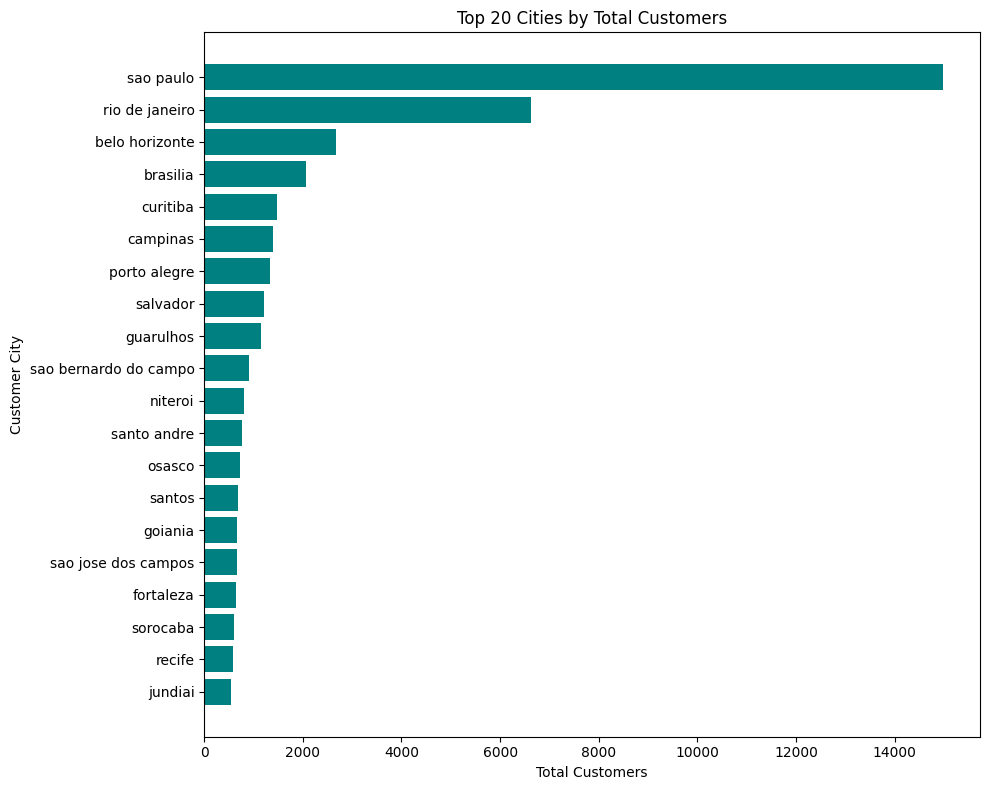

In [377]:
top20 = df_city.head(20)

plt.figure(figsize=(10, 8))
plt.barh(top20['customer_city'], top20['total_customers'],color='teal')
plt.xlabel('Total Customers')
plt.ylabel('Customer City')
plt.title('Top 20 Cities by Total Customers')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [378]:
# Number of customers by states
df_state = (df_join_all
               .groupby('customer_state')
               .agg(total_customers = ('customer_unique_id','nunique'))
               .sort_values(by='total_customers',ascending=False)
               .reset_index())
df_state

,customer_state,total_customers
0,SP,40301
1,RJ,12384
2,MG,11259
3,RS,5276
4,PR,4882
5,SC,3534
6,BA,3277
7,DF,2075
8,ES,1964
9,GO,1952


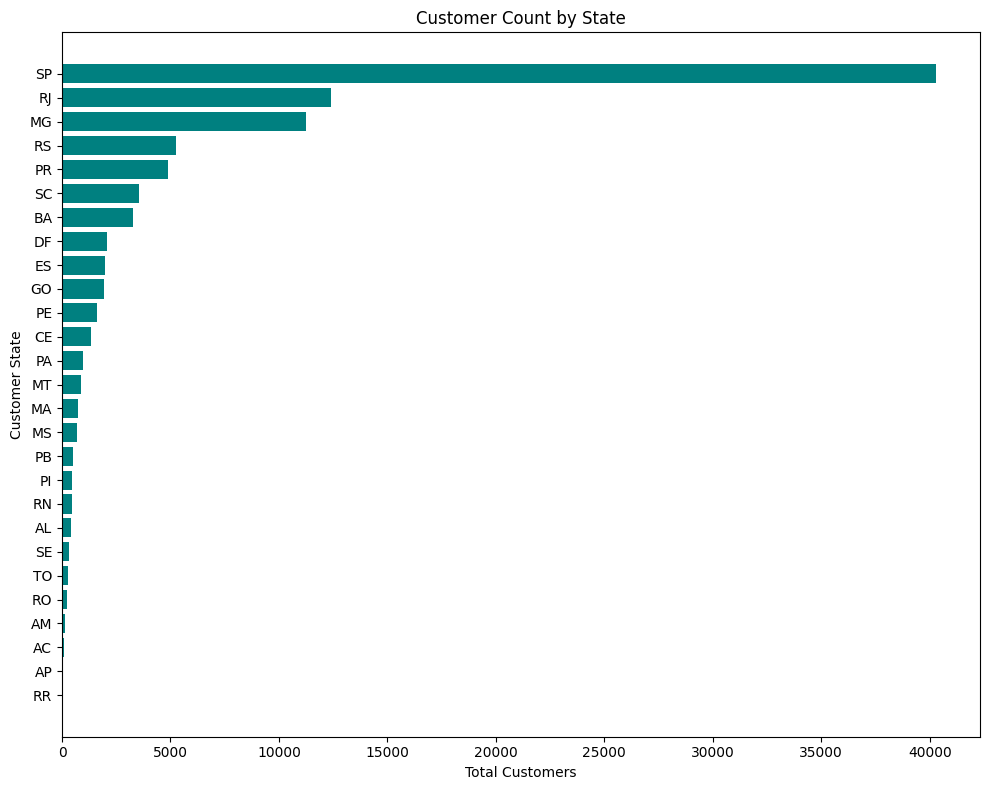

In [379]:
plt.figure(figsize=(10, 8))
plt.barh(df_state['customer_state'], df_state['total_customers'], color='teal')
plt.xlabel('Total Customers')
plt.ylabel('Customer State')
plt.title('Customer Count by State')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2.2. Trend over time

In [380]:
df_join_all['name_day'] = pd.to_datetime(df_join_all['order_purchase_timestamp']).dt.day_name()
df_join_all['hour'] = pd.to_datetime(df_join_all['order_purchase_timestamp']).dt.hour
df_join_all['year_month'] = pd.to_datetime(df_join_all['order_purchase_timestamp']).dt.to_period('M').dt.to_timestamp()


In [381]:
# Trend by year_month
df_month = (
    df_join_all
    .groupby(['year_month'])
    .agg(total_ticket = ('order_id','nunique'))
    .reset_index()
)

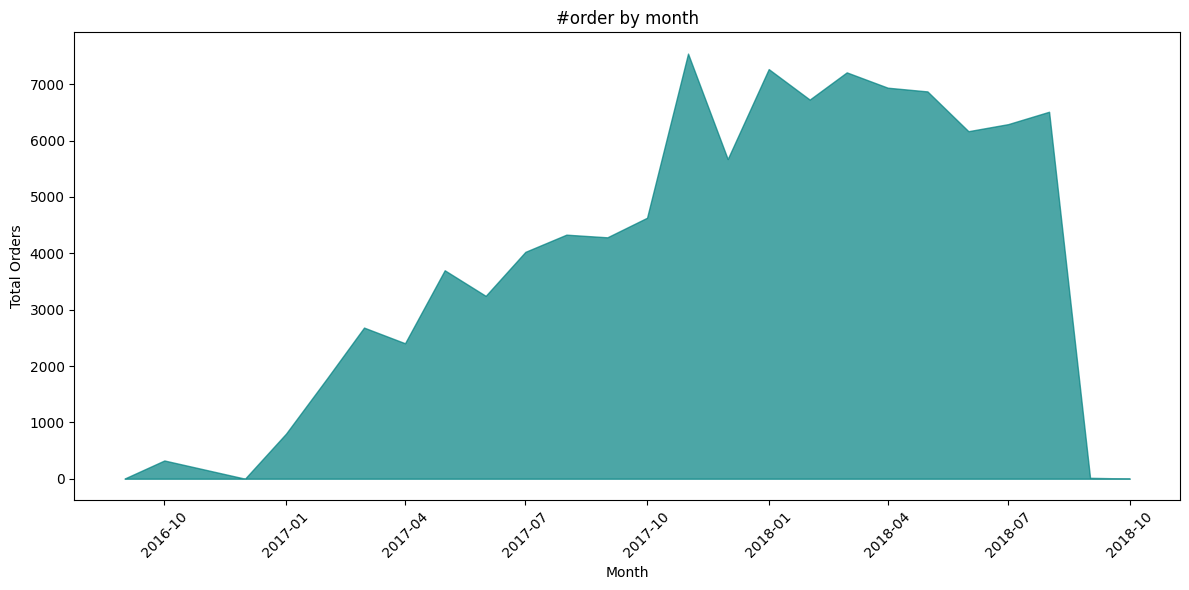

In [382]:
plt.figure(figsize=(12, 6))
plt.fill_between(df_month['year_month'], df_month['total_ticket'], color='teal', alpha=0.7)
plt.title('#order by month')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [383]:
# Trend by weekday
df_week_day = (
    df_join_all
    .groupby(['name_day'])
    .agg(total_ticket = ('order_id','nunique'))
    .reset_index()
)

week_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_week_day['day_order']=pd.Categorical(df_week_day['name_day'], categories = week_order, ordered=True)
df_week_day.sort_values('day_order',inplace=True)

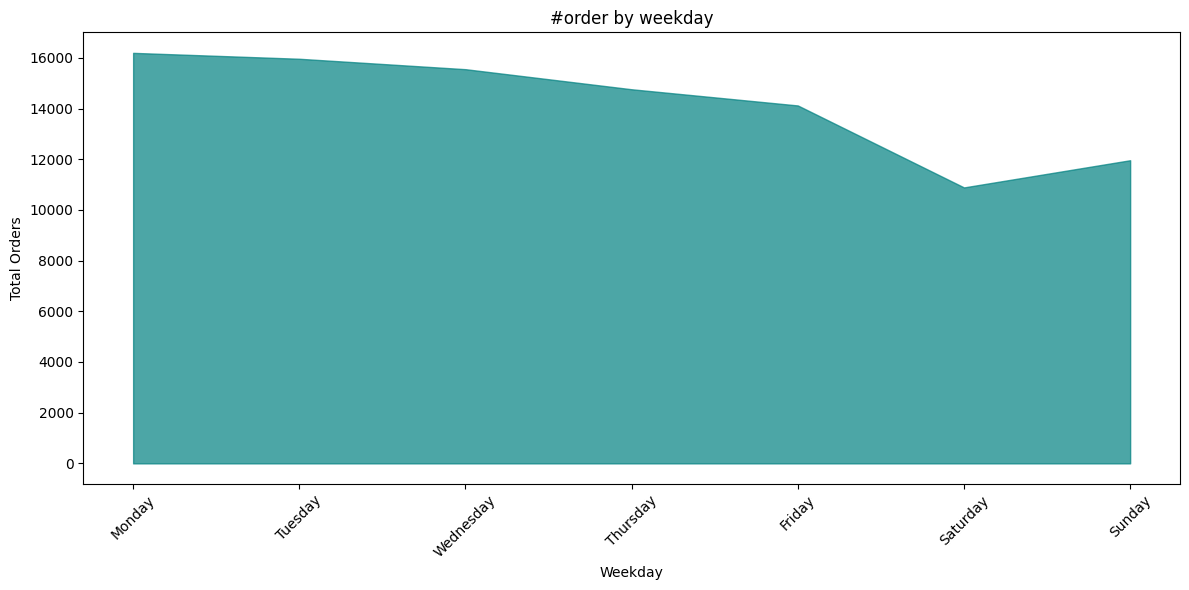

In [384]:
plt.figure(figsize=(12, 6))
plt.fill_between(df_week_day['name_day'], df_week_day['total_ticket'], color='teal', alpha=0.7)
plt.title('#order by weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [385]:
# Trend by hour
df_hour = (
    df_join_all
    .groupby(['hour'])
    .agg(total_ticket = ('order_id','nunique'))
    .reset_index()
)

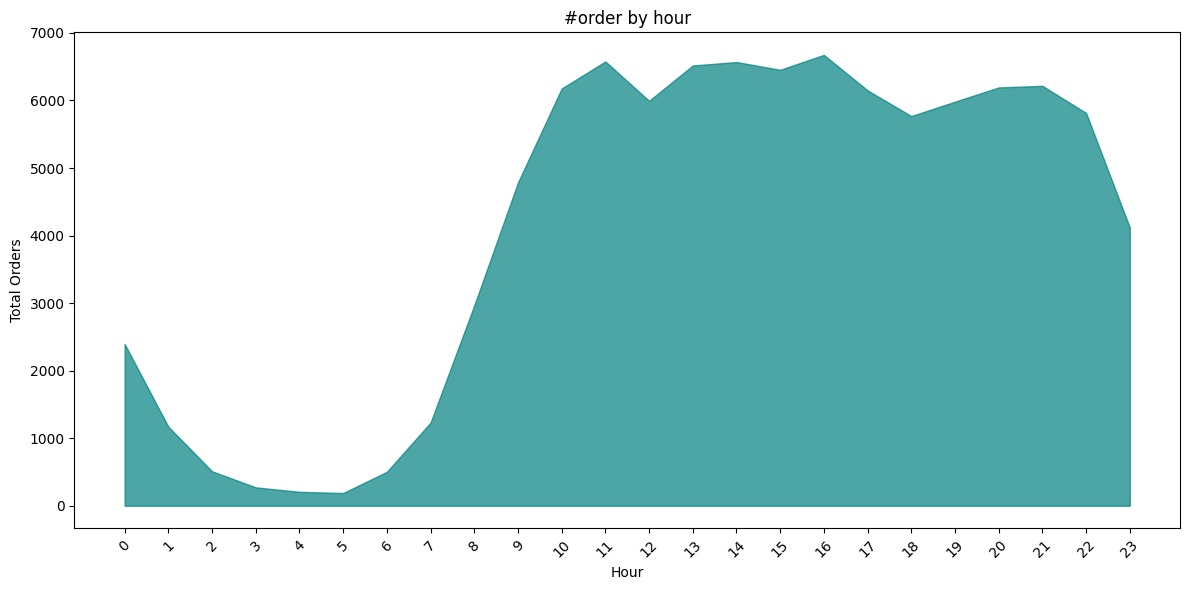

In [386]:
plt.figure(figsize=(12, 6))
plt.fill_between(df_hour['hour'], df_hour['total_ticket'], color='teal', alpha=0.7)
plt.title('#order by hour')
plt.xlabel('Hour')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.xticks(ticks=range(0, 24))
plt.tight_layout()
plt.show()

## 2.3. Factors

### 2.3.1. Payment_type

In [387]:
# Quantity-based perspective
df_payment_type = (df_join_all
                   .groupby('payment_type')
                   .agg(total_order = ('order_id','nunique'))
                   .reset_index())
df_payment_type

,payment_type,total_order
0,boleto,19784
1,credit_card,76503
2,debit_card,1528
3,not_defined,4
4,voucher,3866


In [388]:
df_payment_type = df_payment_type[df_payment_type['payment_type'] != 'not_defined']

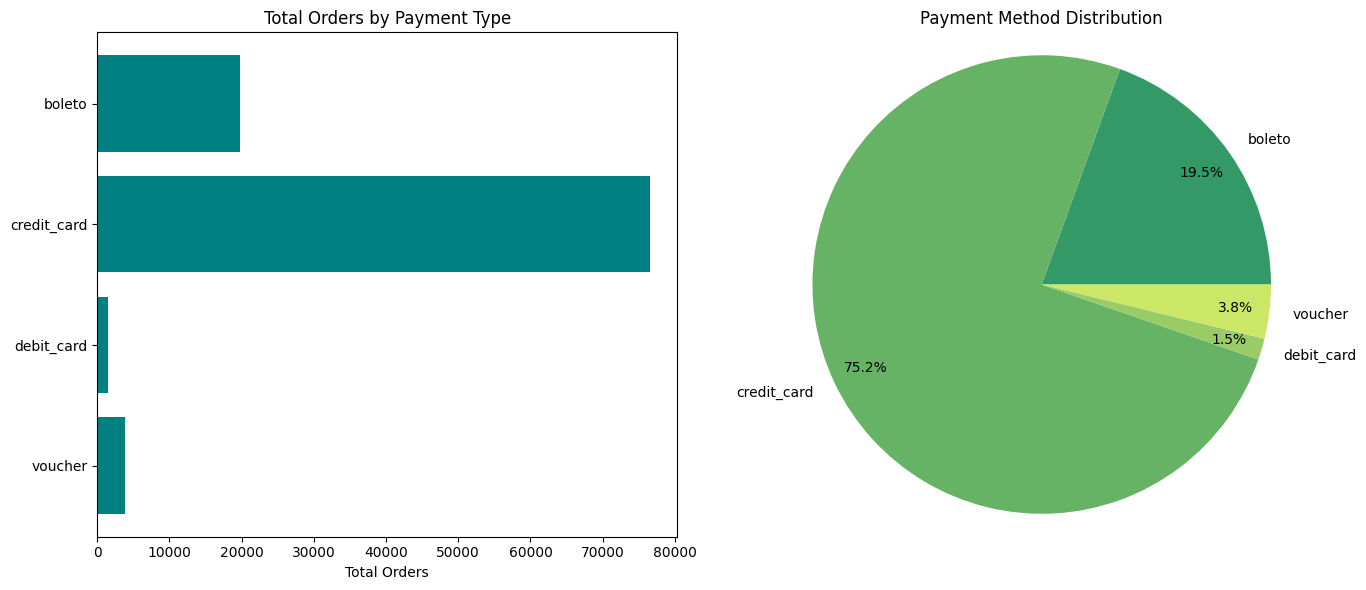

In [389]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].barh(df_payment_type['payment_type'], df_payment_type['total_order'], color='teal')
axs[0].set_xlabel('Total Orders')
axs[0].set_title('Total Orders by Payment Type')
axs[0].invert_yaxis()

colors = sns.color_palette('summer', n_colors=4)
axs[1].pie(df_payment_type['total_order'],
           labels=df_payment_type['payment_type'],
           autopct='%1.1f%%',
           startangle=0,
           colors=colors,
           pctdistance=0.85)
axs[1].set_title('Payment Method Distribution')
axs[1].axis('equal') 

plt.tight_layout()
plt.show()

In [390]:
# Time-based perspective
df_type_time = (df_join_all[(df_join_all['order_status'] == 'delivered') & (df_join_all['payment_type'] != 'not_defined')]
                    .groupby(['year_month','payment_type'])
                    .agg(total_order = ('order_id','count'))
                    .sort_values(by = 'year_month',ascending = True).reset_index())

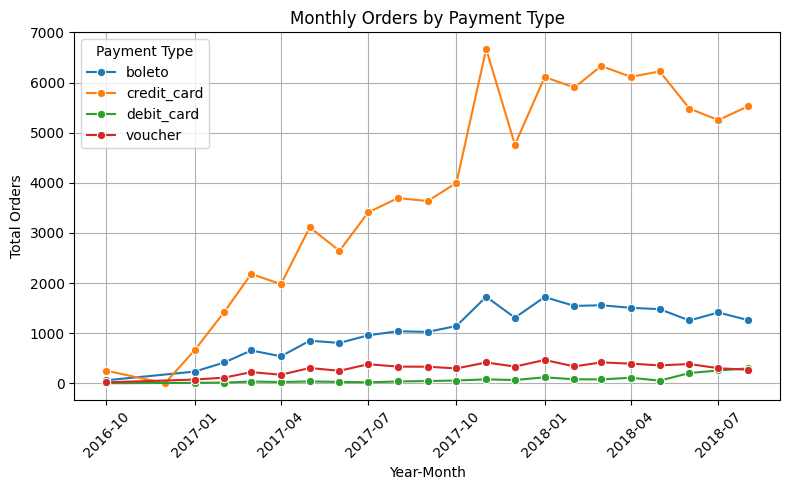

In [391]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_type_time, x='year_month', y='total_order', hue='payment_type', marker='o')

plt.title('Monthly Orders by Payment Type')
plt.xlabel('Year-Month')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Payment Type')
plt.grid(True)
plt.show()

### 2.3.2. Payment installment

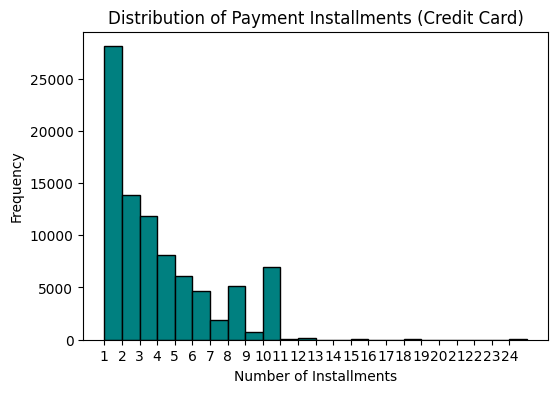

In [392]:
# Distribution of payment installments 
df_credit_card = df_join_all[df_join_all['payment_type'] == 'credit_card'].copy()

plt.figure(figsize=(6,4))
plt.hist(df_credit_card['payment_installments'], bins=range(1, int(df_credit_card['payment_installments'].max())+2), edgecolor='black',color='teal')
plt.xlabel('Number of Installments')
plt.xticks(ticks=np.arange(1, df_credit_card['payment_installments'].max()+1, 1))
plt.ylabel('Frequency')
plt.title('Distribution of Payment Installments (Credit Card)')
plt.show()


In [393]:
df_join_all['price'].describe()

count    118308.000000
mean        120.645617
std         184.111091
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

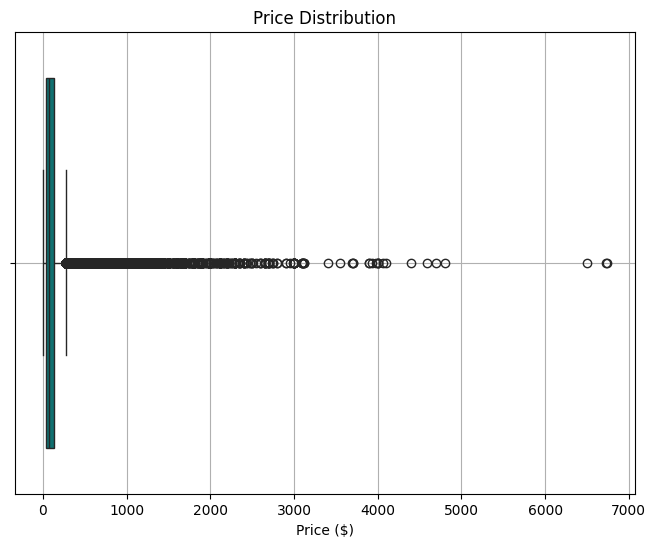

In [394]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df_join_all['price'], color='teal')
plt.xlabel('Price ($)')
plt.title('Price Distribution')
plt.grid(True)
plt.show()

In [395]:
# Correlation between price and payment_installmetns
df_credit_card[['price','payment_value','payment_installments']].corr()

,price,payment_value,payment_installments
price,1.000000,0.763953,0.317951
payment_value,0.763953,1.000000,0.327284
payment_installments,0.317951,0.327284,1.000000


In [396]:
# Time-based perspective

# Average payment value by installments group (Credit card)
df_credit_card['installment_group'] = df_credit_card['payment_installments'].apply(
    lambda x: '1 installment' if x == 1 else
              '2-5 installments' if 2 <= x <= 5 else
              '5+ installments')

In [397]:
df_installment_time = (df_credit_card[(df_credit_card['order_status'] == 'delivered') & (df_credit_card['payment_type'] != 'not_defined')]
                    .groupby(['year_month','installment_group'])
                    .agg(total_order = ('order_id','nunique'))
                    .sort_values(by = 'year_month',ascending = True).reset_index())

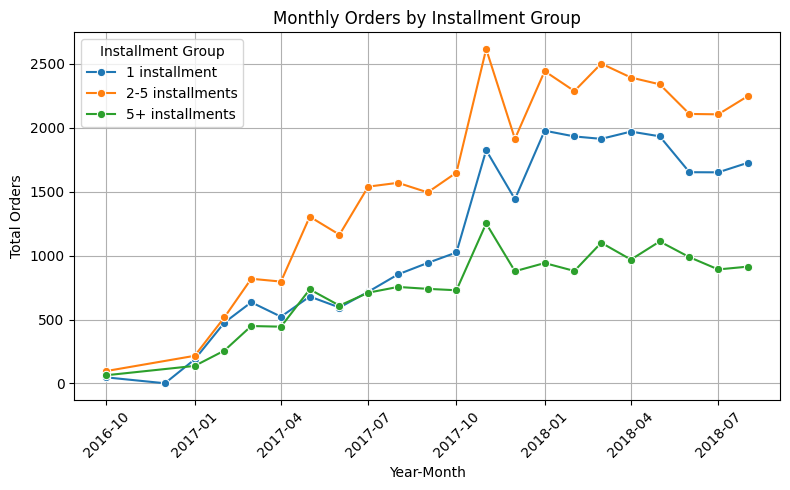

In [398]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_installment_time, x='year_month', y='total_order', hue='installment_group', marker='o')

plt.title('Monthly Orders by Installment Group')
plt.xlabel('Year-Month')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Installment Group')
plt.grid(True)
plt.show()

### 2.3.3. Payment value

In [399]:
df_join_all['payment_value'].describe()

count    119138.000000
mean        172.734778
std         267.778310
min           0.000000
25%          60.850000
50%         108.155000
75%         189.235000
max       13664.080000
Name: payment_value, dtype: float64

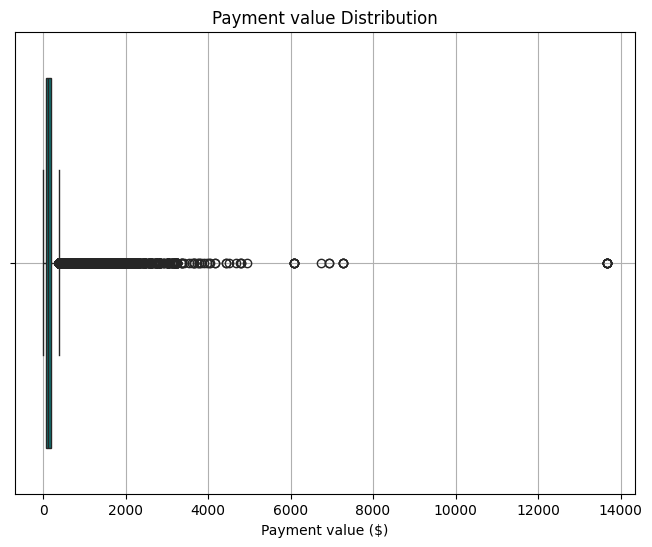

In [400]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df_join_all['payment_value'], color='teal')
plt.xlabel('Payment value ($)')
plt.title('Payment value Distribution')
plt.grid(True)
plt.show()

### 2.3.4. Products

In [401]:
df_product_cate = (df_join_all[df_join_all['order_status'] == 'delivered']
            .groupby('product_category_name_english')
            .agg(total_order = ('order_id','nunique'))
            .sort_values(by='total_order',ascending=False)
            .reset_index())
df_product_cate

,product_category_name_english,total_order
0,bed_bath_table,9272
1,health_beauty,8647
2,sports_leisure,7529
3,computers_accessories,6530
4,furniture_decor,6306
...,...,...
66,arts_and_craftmanship,23
67,la_cuisine,13
68,cds_dvds_musicals,12
69,fashion_childrens_clothes,7


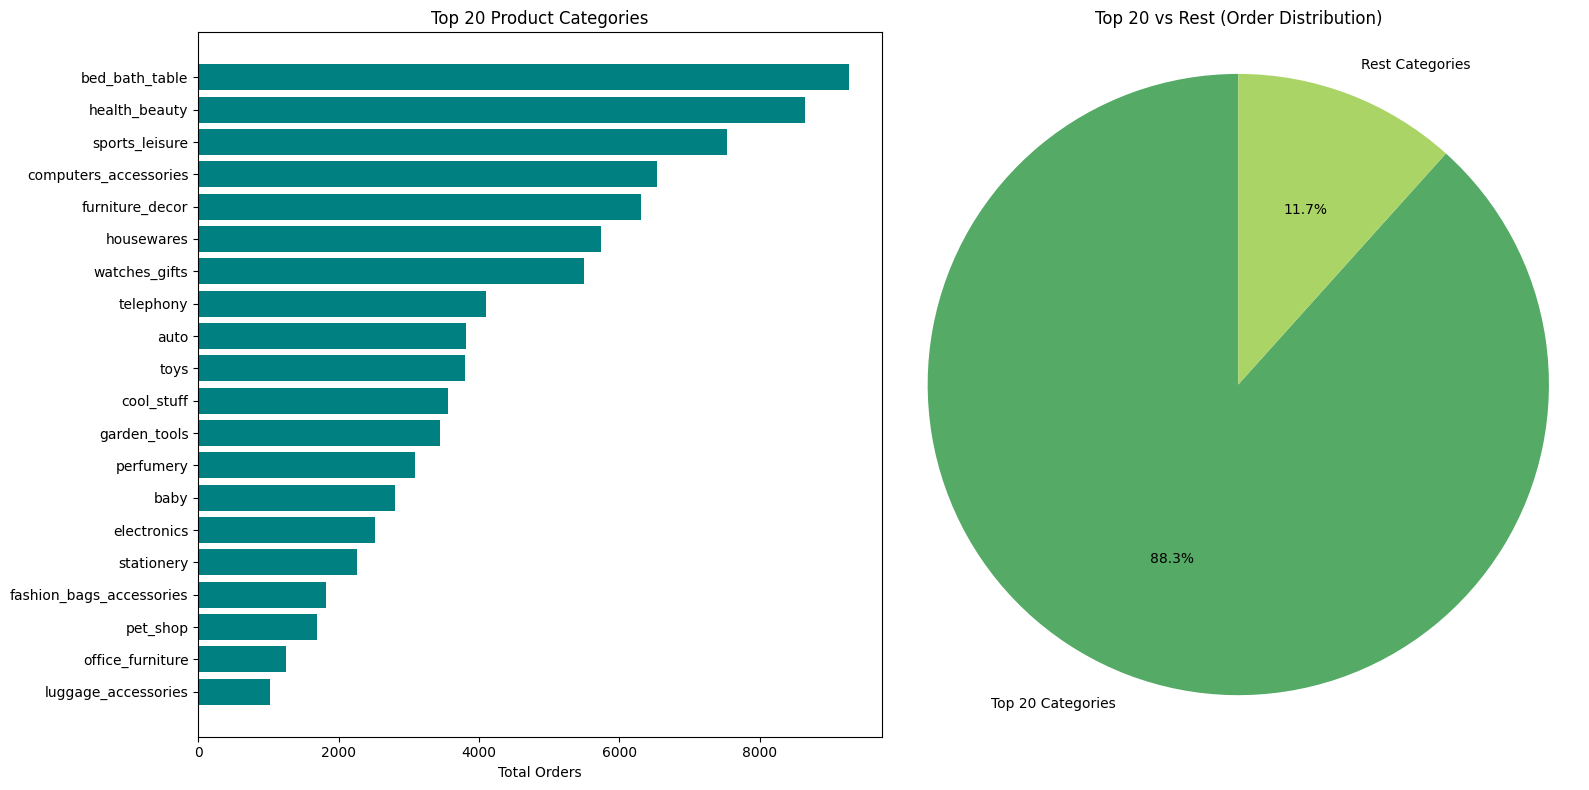

In [402]:
df_top20 = df_product_cate.head(20)
top20_sum = df_top20['total_order'].sum()
rest_sum = df_product_cate['total_order'].sum() - top20_sum

fig, axs = plt.subplots(1, 2, figsize=(16, 8)) 

axs[0].barh(
    df_top20['product_category_name_english'], 
    df_top20['total_order'], 
    color='Teal'
)
axs[0].set_xlabel('Total Orders')
axs[0].set_title('Top 20 Product Categories')
axs[0].invert_yaxis()

colors = sns.color_palette('summer', n_colors=2)
axs[1].pie(
    [top20_sum, rest_sum],
    labels=['Top 20 Categories', 'Rest Categories'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.6
)
axs[1].set_title('Top 20 vs Rest (Order Distribution)')
axs[1].axis('equal')

plt.tight_layout()
plt.show()


C:\Users\tranv\AppData\Local\Temp\ipykernel_23508\3242679056.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


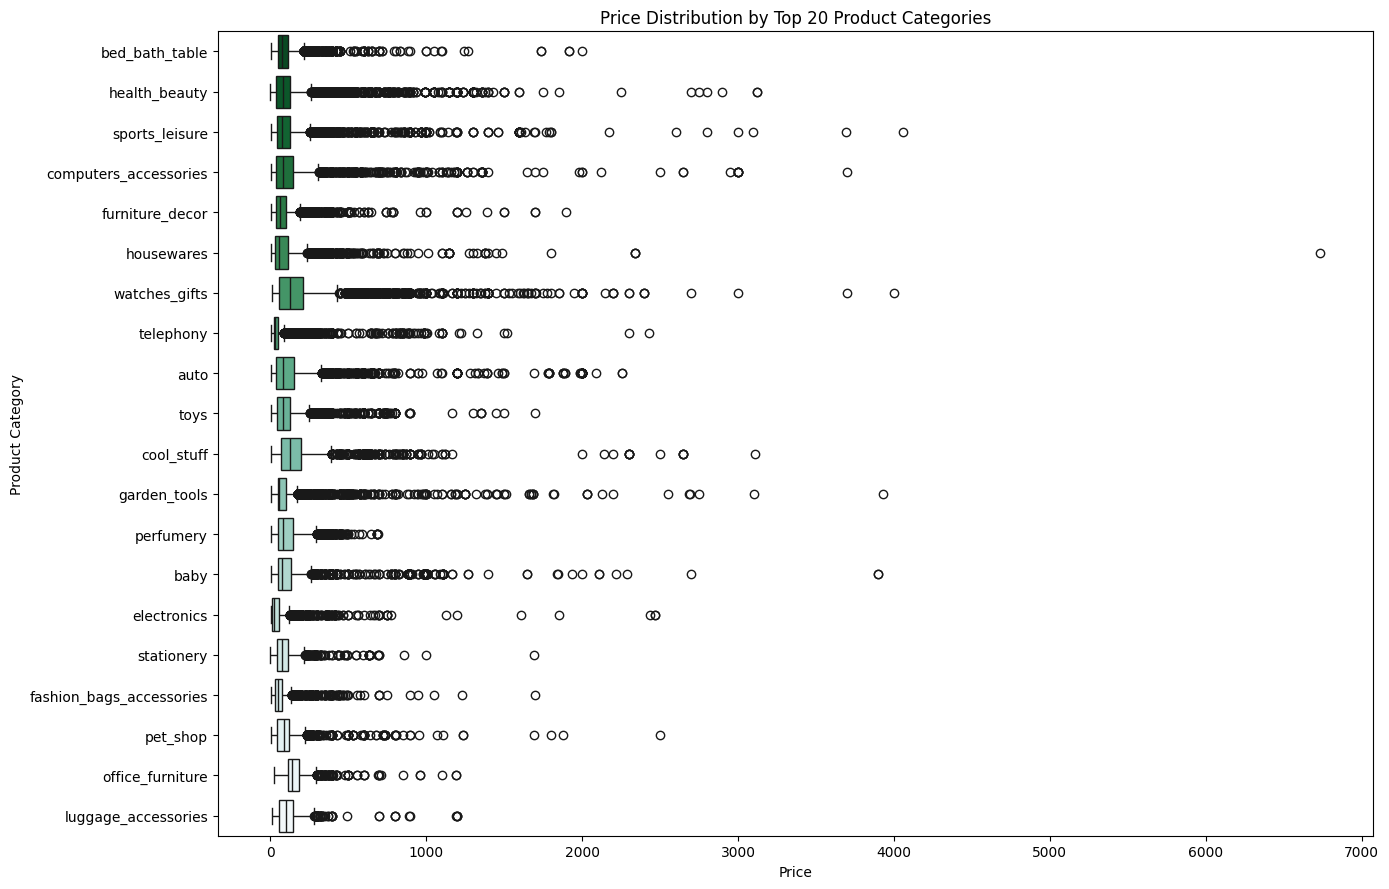

In [403]:
top_20_categories = df_product_cate['product_category_name_english'].head(20)

df_top20_dis = df_join_all[df_join_all['product_category_name_english'].isin(top_20_categories)]

plt.figure(figsize=(14, 9))
sns.boxplot(
    data=df_top20_dis,
    x='price',
    y='product_category_name_english',
    order=top_20_categories, 
    orient='h',
    palette='BuGn_r'
)

plt.title('Price Distribution by Top 20 Product Categories')
plt.xlabel('Price')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

## 2.4. Customer journey

### 2.4.1. Retention rate

In [404]:
print(df_join_all['order_purchase_timestamp'].min())
print(df_join_all['order_purchase_timestamp'].max())

2016-09-04 21:15:19
2018-10-17 17:30:18


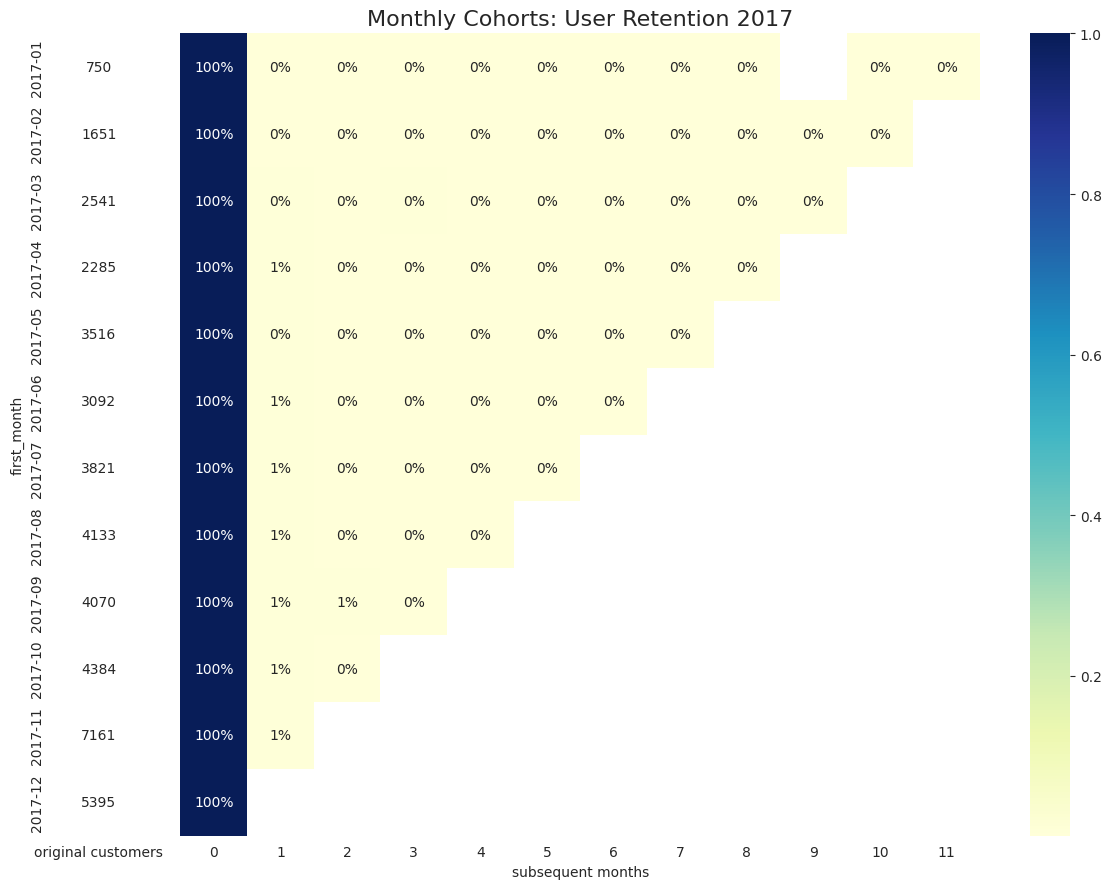

In [405]:
# step 1: cohort (firstmonth), current month and subsequent month    (2017)

df_selected_time = df_join_all[(df_join_all['order_purchase_timestamp'] > '2017-01-01') & (df_join_all['order_purchase_timestamp'] < '2018-01-01') & (df_join_all['order_status'] =='delivered')].copy() 

df_selected_time['first_month'] = df_selected_time.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

df_selected_time['current_month'] = df_selected_time['order_purchase_timestamp'].dt.to_period('M')

df_selected_time['subsequent_month'] = (df_selected_time['current_month'] - df_selected_time['first_month']).apply(attrgetter('n'))

# step 2: group by cohort

df_cohort = (
    df_selected_time
    .groupby(['first_month','current_month','subsequent_month'])
    .agg(n_customer = ('customer_id','nunique'))
    .reset_index(drop=False)
) 

# pivot the result of df_cohort

df_cohort_pivot = (
    df_cohort
    .pivot_table(index='first_month', columns='subsequent_month', values= 'n_customer')
)

# Turn result into % 

cohort_size = df_cohort_pivot.iloc[:,0]
retention_matrix = df_cohort_pivot.divide(cohort_size, axis=0)

# visualization

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 9), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='YlGnBu',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention 2017', fontsize=16)
    ax[1].set(xlabel='subsequent months',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'original customers'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                alpha=0.5,
                ax=ax[0])

    fig.tight_layout()

plt.show()

### 2.4.2. Review

In [406]:
No_review = df_join_all['review_comment_message'].isna().sum()
Review = len(df_join_all) - No_review

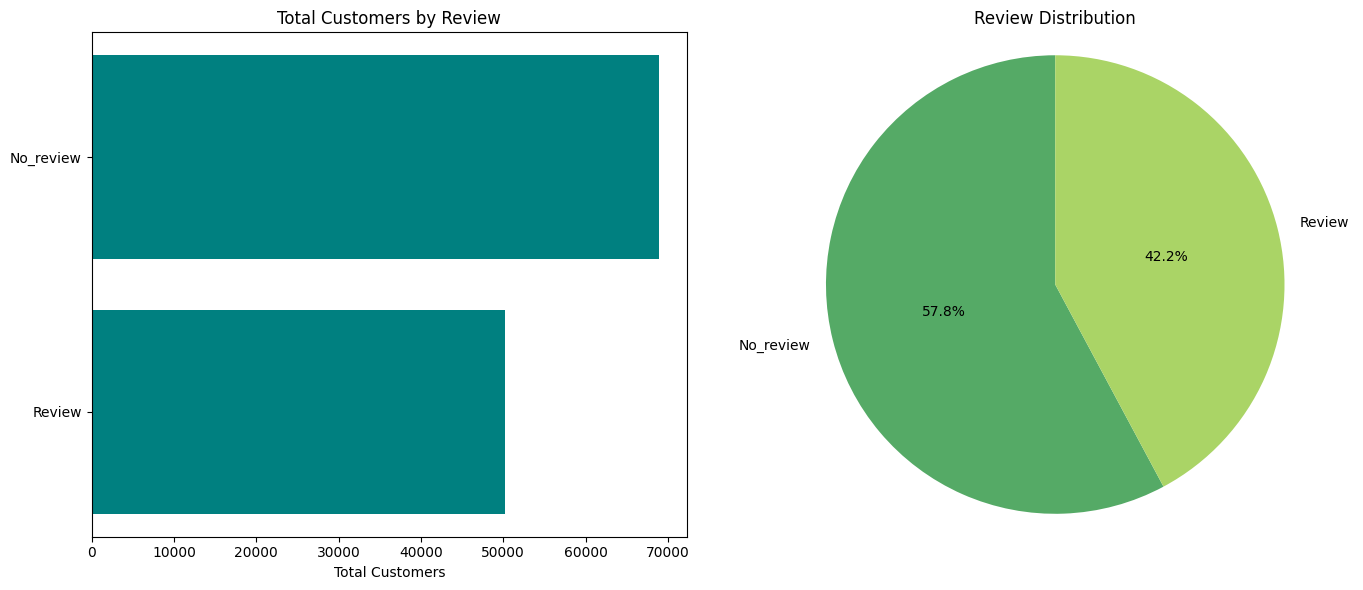

In [407]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].barh(['No_review', 'Review'], [No_review, Review], color='teal')
axs[0].set_xlabel('Total Customers')
axs[0].set_title('Total Customers by Review')
axs[0].invert_yaxis()

colors = sns.color_palette('summer', n_colors=2)
axs[1].pie([No_review,Review],
           labels=['No_review','Review'],
           autopct='%1.1f%%',
           startangle=90,
           colors=colors,
           pctdistance=0.50)
axs[1].set_title('Review Distribution')
axs[1].axis('equal') 

plt.tight_layout()
plt.show()

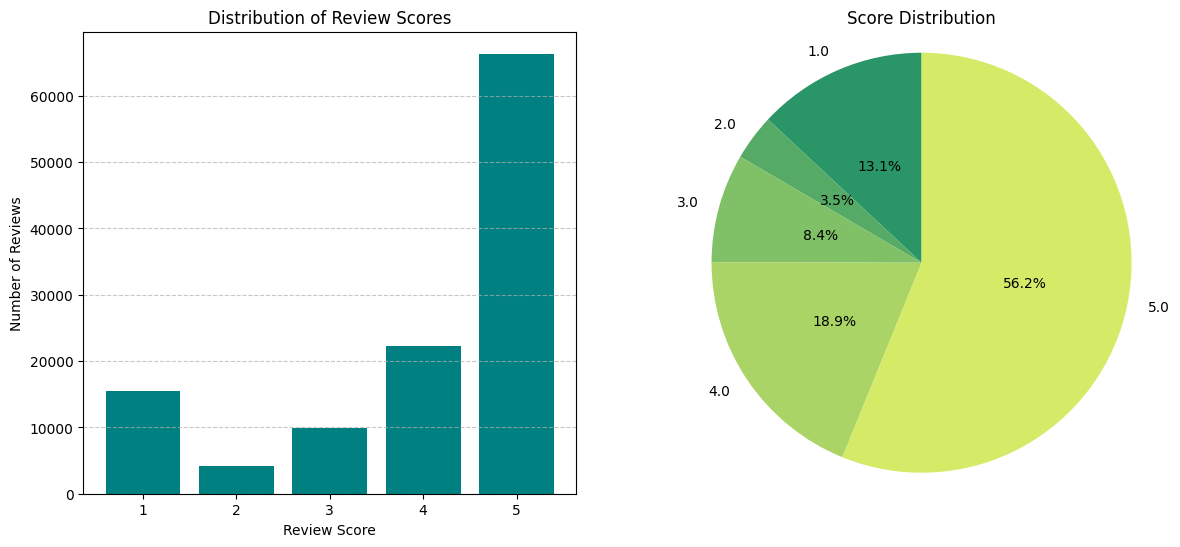

In [408]:
# Distribution of score
score_counts = df_join_all['review_score'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(score_counts.index, score_counts.values, color='teal')
axs[0].set_xlabel('Review Score')
axs[0].set_ylabel('Number of Reviews')
axs[0].set_title('Distribution of Review Scores')
axs[0].set_xticks(score_counts.index)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

colors = sns.color_palette('summer', n_colors=len(score_counts))
axs[1].pie(score_counts.values,
           labels=score_counts.index,
           autopct='%1.1f%%',
           colors = colors,
           startangle=90,
           pctdistance=0.50)
axs[1].set_title('Score Distribution')
axs[1].axis('equal')
plt.show()

# 3. Customer Segmentation Analysis

In this part, we are going to devide customers into groups based on order_value, review, installments to identify potential customers

In [409]:
df_segment = df_join_all.groupby('customer_unique_id').agg({
    'payment_value': ['sum', 'mean', 'count'],
    'review_score': ['mean', 'count'],
    'payment_installments' : ['mean','count']
}).reset_index()

In [410]:
df_segment

customer_unique_id payment_value                 \
                                                  sum     mean count   
0      0000366f3b9a7992bf8c76cfdf3221e2        141.90   141.90     1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f         27.19    27.19     1   
2      0000f46a3911fa3c0805444483337064         86.22    86.22     1   
3      0000f6ccb0745a6a4b88665a16c9f078         43.62    43.62     1   
4      0004aac84e0df4da2b147fca70cf8255        196.89   196.89     1   
...                                 ...           ...      ...   ...   
96089  fffcf5a5ff07b0908bd4e2dbc735a684       4134.84  2067.42     2   
96090  fffea47cd6d3cc0a88bd621562a9d061         84.58    84.58     1   
96091  ffff371b4d645b6ecea244b27531430a        112.46   112.46     1   
96092  ffff5962728ec6157033ef9805bacc48        133.69   133.69     1   
96093  ffffd2657e2aad2907e67c3e9daecbeb         71.56    71.56     1   

      review_score       payment_installments        
              mean count                 mean count  
0              5.0     1                  8.0     1  
1              4.0     1                  1.0     1  
2              3.0     1                  8.0     1  
3              4.0     1                  4.0     1  
4              5.0     1                  6.0     1  
...            ...   ...                  ...   ...  
96089          5.0     2                 10.0     2  
96090          4.0     1                  1.0     1  
96091          5.0     1                  1.0     1  
96092          5.0     1                  5.0     1  
96093          5.0     1                  4.0     1  

[96094 rows x 8 columns]

In [411]:
df_segment.columns = ['customer_unique_id', 'total_order_value', 'avg_order_value', 'order_count',
                       'avg_review_score', 'review_count','avg_installments','installment_count']

In [412]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['avg_order_value', 'avg_review_score', 'avg_installments']
X = df_segment[features].fillna(0) 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


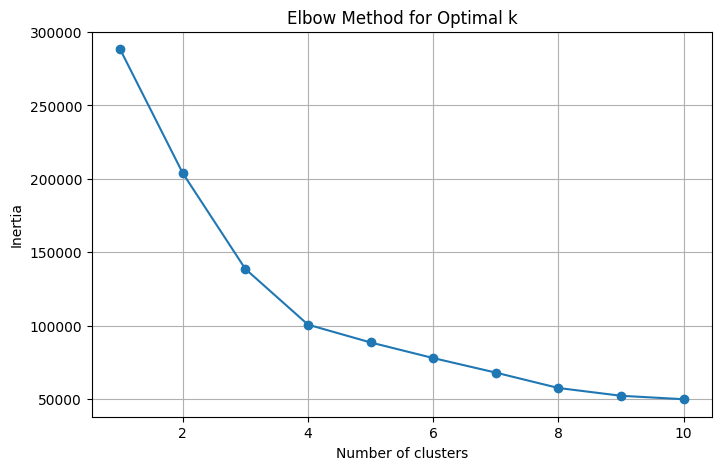

In [413]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [414]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_segment['cluster'] = kmeans.fit_predict(X_scaled)


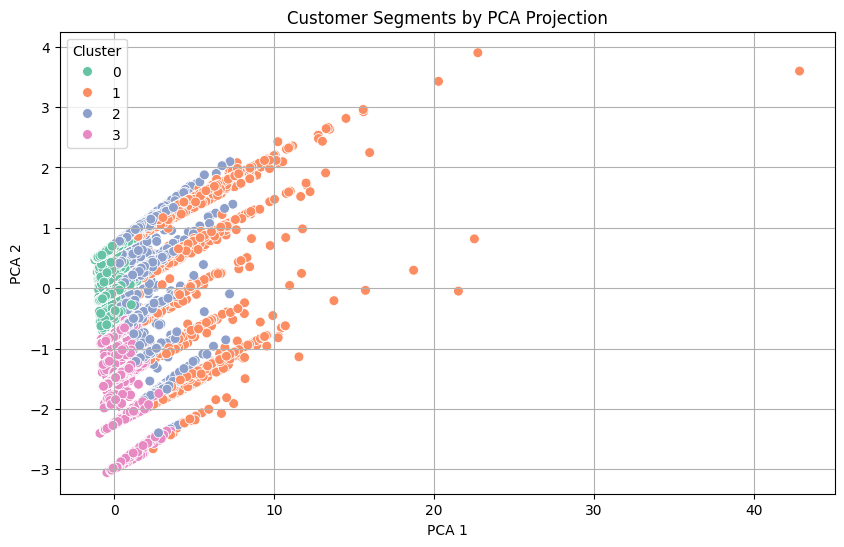

In [415]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_segment['pca_1'] = pca_result[:, 0]
df_segment['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_segment, x='pca_1', y='pca_2', hue='cluster', palette='Set2', s=50)
plt.title('Customer Segments by PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [416]:
# Group by cluster and calculate the mean of each feature
cluster_profiles = df_segment.groupby('cluster')[['avg_order_value', 'avg_review_score', 'avg_installments']].mean().round(2)

# Add count of customers per cluster
cluster_profiles['count_customers'] = df_segment['cluster'].value_counts().sort_index()

print(cluster_profiles)




         avg_order_value  avg_review_score  avg_installments  count_customers
cluster                                                                      
0                 113.28              4.74              1.68            57748
1                1297.99              3.85              6.42             1846
2                 220.97              4.40              7.44            16817
3                 132.61              1.83              2.28            19683


###  Customer Segmentation Notes

- **Cluster 0 –  Majority Group**  
  - **Avg Order Value**: 113.28  
  - **Avg Review Score**: 4.74  
  - **Avg Installments**: 1.68  
  - **Customers**: 57,748  
  - **Interpretation**: These are low spenders, but very satisfied. They prefer to pay in full. Likely value-conscious loyal customers.

- **Cluster 1 –  High-Value Elite**  
  - **Avg Order Value**: 1297.99  
  - **Avg Review Score**: 3.85  
  - **Avg Installments**: 6.42  
  - **Customers**: 1,846  
  - **Interpretation**: These are very high spenders with moderate satisfaction and frequent installment use. Likely premium shoppers or big- buyers.

- **Cluster 2 –  Installment Lovers**  
  - **Avg Order Value**: 220.97  
  - **Avg Review Score**: 4.40  
  - **Avg Installments**: 7.44  
  - **Customers**: 16,817  
  - **Interpretation**: Medium-value customers with good satisfaction who strongly prefer installment payments. Likely budget-focused but engaged.

- **Cluster 3 –  At-Risk Group**  
  - **Avg Order Value**: 132.61  
  - **Avg Review Score**: 1.83  
  - **Avg Installments**: 2.28  
  - **Customers**: 19,683  
  - **Interpretation**: Low-value customers with very low satisfaction. Possibly unhappy or one-time buyers. Needs intervention to improve retention.
